In [1]:
import numpy as np
import scipy as sp
from petsc4py import PETSc
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import urllib
import shutil
import hashlib
import xhermes
import xbout
import sys
from pathlib import Path
sys.path.append("/home/mike/work/sdtools")
from hermes3.case_db import *
from boutdata.data import BoutOptionsFile
from boututils.run_wrapper import shell, launch, getmpirun

%load_ext autoreload
%autoreload 2

Failed to import dill, some functionality will not be available.


# Paths

In [2]:
# cwd = Path.cwd()
cwd = Path(r"/home/mike/work/hermes3v/builds/newbuild/tests/integrated/dmplex")
case_path = cwd / "data"
datafile_path = case_path / "BOUT.dmp.*.nc"
inputfile_path = case_path / "BOUT.inp"
exec_path = cwd.parents[2] / "bout-particle-push"
dmplex_path = cwd / "hypnotoad_dmplex_mesh_output.h5"
logfile_path = cwd / "run.log"

gridzipfile_path = cwd / "Hypnotoad_examples.zip"
gridurl = "https://zenodo.org/records/17966926/files/Hypnotoad_examples.zip"


hypno = xhermes.HypnotoadGrid(r"/home/mike/work/hermes3v/builds/newbuild/tests/integrated/dmplex/example_usn.grd.nc")
hypno_ng = hypno.remove_guards()


In [17]:

inputfile = BoutOptionsFile(inputfile_path)


*


TEST


/home/mike/work/hermes3v/external/boutdata/src/boutdata/data.py:764: AlwaysWarning: While building x, y, z coordinate arrays, an exception occured: [Errno 2] No such file or directory: 'example_usn.grd.nc'
Evaluating non-scalar options not available
  + str(e)


# Read DMPlex

In [3]:

dm = PETSc.DMPlex().create()
viewer = PETSc.Viewer().createHDF5(str(dmplex_path), 'r')

dm.load(viewer)
viewer.destroy()
dm.setFromOptions()
dm.setUp()

coords = dm.getCoordinatesLocal().array  # Get all RZ coordinates
section = dm.getCoordinateSection()  
dim = dm.getCoordinateDim()  # Number of dimensions in the grid

## Get vertices
vertex_start, vertex_end = dm.getDepthStratum(0)  # vertices are the simplest object, so depth = 0
R = []
Z = []

for p in range(vertex_start, vertex_end):
    ndof = section.getDof(p)  # Number of degrees of freedom at point p
    off = section.getOffset(p)  # Find offset to locate matching coordinates to point p
    
    R.append(coords[off])
    Z.append(coords[off+1])

dmplex_vertices = np.column_stack((R,Z))

## Get edges
edge_start, edge_end = dm.getDepthStratum(1)  # Edges are one level deeper than vertices
edges = []

for p in range(edge_start, edge_end):
    cone = dm.getCone(p)
    
    if len(cone) == 2:
        v0, v1 = cone
        x0 = coords[section.getOffset(v0):section.getOffset(v0)+dim]
        x1 = coords[section.getOffset(v1):section.getOffset(v1)+dim]
        edges.append((x0, x1))



## DMPlex test plot

(-0.6020256974441909, 0.1)

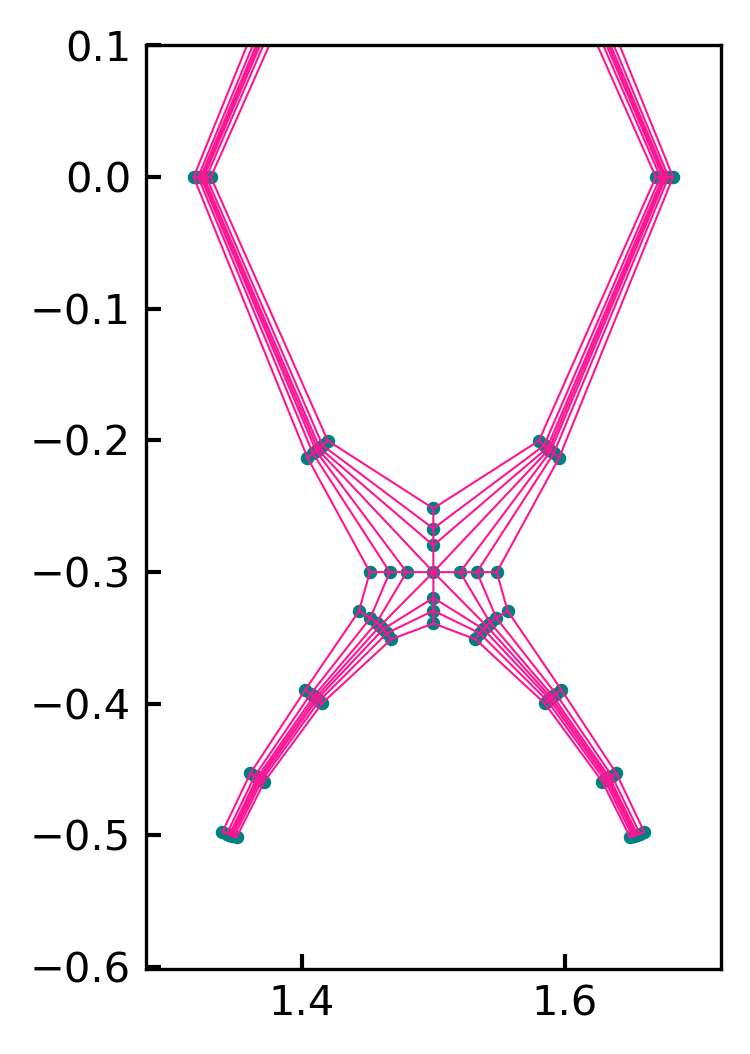

In [10]:
fig, ax = plt.subplots(dpi = 300)

for x0, x1 in edges:
    ax.plot([x0[0], x1[0]], [x0[1], x1[1]], color='deeppink', linewidth=0.5)
ax.scatter(R,Z, s = 5)
ax.set_aspect("equal")
ax.set_ylim(None, 0.1)

# Auto change input file

In [19]:
grids = dict(
    cdn = Path(r"/home/mike/work/cases/example_cdn.grd.nc"),
    cdn_noguards = Path(r"/home/mike/work/cases/example_cdn_noguards.grd.nc"),
    ldn = Path(r"/home/mike/work/cases/example_ldn.grd.nc"),
    ldn_noguards = Path( r"/home/mike/work/cases/example_ldn_noguards.grd.nc"),
    lsn = Path(r"/home/mike/work/cases/example_lsn.grd.nc"),
    lsn_noguards = Path(r"/home/mike/work/cases/example_lsn_noguards.grd.nc"),
    usn = Path(r"/home/mike/work/cases/example_usn.grd.nc"),
    usn_noguards = Path(r"/home/mike/work/cases/example_usn_noguards.grd.nc"),
    udn2 = Path(r"/home/mike/work/cases/example_udn2.grd.nc"),
    udn2_noguards = Path(r"/home/mike/work/cases/example_udn2_noguards.grd.nc"),
)

test_path = Path(r"/home/mike/work/cases/vantage/test/")

# Load grid
grid_name = "usn"
grid_path = grids[grid_name]
grid_filename = grids[grid_name].parent
ds = xhermes.HypnotoadGrid(grid_path)

# Figure out how many cores to run on
ncores = ds.num_processors(1, 12)[0]
print(f'"{grid_name}" : {ds.num_processors(1, 12)}, ')
    
# Edit input file to change to the correct grid
inputfile_path = test_path / "BOUT.inp"
inputfile = BoutOptionsFile(inputfile_path)
inputfile["mesh"]["file"] = grid_filename
inputfile.write(inputfile_path, overwrite = True)

# Run the test
exec_path = r"/home/mike/work/hermes3v/builds/newbuild/bout-particle-push"

# s, out = launch(f"{exec_path} -d {test_path}", nproc=ncores, mthread=1, pipe=True)
# print(s)
# print(out)

"usn" : [4, 8], 


/home/mike/work/hermes3v/views/gcc/lib/python3.11/site-packages/boutdata/data.py:765: AlwaysWarning: While building x, y, z coordinate arrays, an exception occured: [Errno -51] NetCDF: Unknown file format: '/home/mike/work/cases'
Evaluating non-scalar options not available
  alwayswarn(


# Read Hypnotoad

In [53]:
gridfiles = ["example_cdn.grd.nc",
            "example_ldn.grd.nc",
            "example_lsn.grd.nc",
            "example_udn.grd.nc",
            "example_udn2.grd.nc",
            "example_usn.grd.nc"]


path = Path(r"/home/mike/work/hermes3v/builds/newbuild/tests/integrated/dmplex/")

for p in path.rglob("*.grd.nc"):
    print("\n",p.name)
# [print(p) for p in path.rglob("*.grd.nc")]
    hypno = xhermes.HypnotoadGrid(p)
    print(hypno["J"][:2,:2])


 example_udn2.grd.nc
[[0.00068433 0.00611156]
 [0.00069187 0.00617701]]

 example_udn2_noguards.grd.nc
[[0.02994657 0.05509732]
 [0.03025885 0.05641245]]

 example_usn_noguards.grd.nc
[[0.04239735 0.06550338]
 [0.04262456 0.06587716]]

 example_cdn.grd.nc
[[0.00065355 0.00620177]
 [0.00065534 0.00621754]]

 example_lsn.grd.nc
[[0.00472182 0.01415186]
 [0.00473729 0.01418963]]

 example_lsn_noguards.grd.nc
[[0.03533519 0.0571828 ]
 [0.03538614 0.05727552]]

 example_cdn_noguards.grd.nc
[[0.0312486  0.05837332]
 [0.03129792 0.05846902]]

 example_udn.grd.nc
[[0.00065592 0.0061894 ]
 [0.00065777 0.00620574]]

 example_ldn_noguards.grd.nc
[[-0.03124945 -0.058376  ]
 [-0.03129868 -0.0584712 ]]

 example_usn.grd.nc
[[0.00580601 0.0173109 ]
 [0.00584841 0.01742618]]

 example_udn_noguards.grd.nc
[[0.03111902 0.05812232]
 [0.03117438 0.05827012]]

 example_ldn.grd.nc
[[-0.00065345 -0.00620157]
 [-0.00065524 -0.00621731]]


# Compare corners

In [10]:
corners = {}
allcorners = []
side_names = ["lower_left", "lower_right", "upper_left", "upper_right"]

Rxy_names = [f"Rxy_{side}_corners" for side in side_names]
Zxy_names = [f"Zxy_{side}_corners" for side in side_names]

Rxy_corners = np.concatenate([hypno_ng[f"Rxy_{side}_corners"] for side in side_names], axis =0)
Zxy_corners = np.concatenate([hypno_ng[f"Zxy_{side}_corners"] for side in side_names], axis =0)

hypno_vertices = np.column_stack((Rxy_corners.flatten(), Zxy_corners.flatten()))

# dmplex_vertices = 

In [13]:
np.sqrt(R_hypno_current**2 + Z_hypno_current**2)

1.7243930128215554

In [14]:
np.sqrt(R_dmplex**2 + Z_dmplex**2)

array([1.72439301, 1.68791338, 1.6320847 , 1.57401883, 1.7258448 ,
       1.68929554, 1.63362379, 1.57619481, 1.72689894, 1.69030281,
       1.63476439, 1.57803628, 1.72775446, 1.69112251, 1.63570394,
       1.57968629, 1.72867486, 1.69200661, 1.63672831, 1.58160435,
       1.73018504, 1.69346209, 1.63843852, 1.58502302, 1.73287195,
       1.6960663 , 1.64156686, 1.59165871, 1.56597277, 1.6391847 ,
       1.65541315, 1.57143968, 1.64251304, 1.65863155, 1.57467022,
       1.64437393, 1.6604269 , 1.57668645, 1.64550463, 1.66151641,
       1.54907111, 1.57873568, 1.64663389, 1.66260352, 1.56125609,
       1.58216254, 1.64848619, 1.66438449, 1.57567324, 1.58840145,
       1.65177996, 1.66754496, 1.52119428, 1.52373638, 1.52599076,
       1.50853184, 1.34620301, 1.37144971, 1.46918453, 1.50890013,
       1.34306043, 1.36841611, 1.46538606, 1.50910881, 1.34130808,
       1.36671991, 1.46306038, 1.50923656, 1.34024493, 1.36568923,
       1.4615806 , 1.50936488, 1.33918431, 1.36465982, 1.46005

In [ ]:
R_dmplex = dmplex_vertices[:, 0]
Z_dmplex = dmplex_vertices[:, 1]
R_hypno = hypno_vertices[:, 0]
Z_hypno = hypno_vertices[:, 1]

i = 0

# Find the nearest distance from the i-th Hypnotoad vertex to any DMPLex vertex
# and test if it's small enough relative to the scale of the geometry
nearest_distance = np.min(np.sqrt((R_dmplex - R_hypno[i])**2 + (Z_dmplex - Z_hypno[i])**2))
geometry_size = np.max(np.sqrt(R_hypno**2 + Z_hypno**2))
tolerance = 1e-6 * geometry_size


nearest_distance
geometry_size

1.732871946382981

In [27]:
import requests

ModuleNotFoundError: No module named 'requests'

# Better download

In [ ]:


file_hash

'fd91d0c0d0595bc3ea6b3aacb6950c9c306ac3574c228c3b27626bb237885874'

In [4]:
gridzipfile_path


PosixPath('/home/mike/work/hermes3v/builds/newbuild/tests/integrated/dmplex/Hypnotoad_examples.zip')

In [7]:
tmp_path = gridzipfile_path.with_name(gridzipfile_path.name + ".tmp")

with urllib.request.urlopen(gridurl, timeout=60) as response:

    if response.status != 200:
        raise RuntimeError(f"Test grid download failed: HTTP {response.status}")
    
    # Copy bits of the file from response to a temp file
    # This ensures no partial files are left if the download fails
    with open(tmp_path, "wb") as out_file:
        shutil.copyfileobj(response, out_file)

# Rename temp file with the correct name
tmp_path.replace(gridzipfile_path)

PosixPath('/home/mike/work/hermes3v/builds/newbuild/tests/integrated/dmplex/Hypnotoad_examples.zip')

In [6]:
tmp_path

PosixPath('/home/mike/work/hermes3v/builds/newbuild/tests/integrated/dmplex/Hypnotoad_examples.zip.tmp')

In [ ]:
with requests.get(gridurl, stream=True, timeout=60) as r:
    r.raise_for_status()
    with open(gridzipfile, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)

array([1.649829  , 1.62565539, 1.58295905, 1.53420741, 1.65155639,
       1.62738751, 1.58499208, 1.53736963, 1.65280926, 1.62864631,
       1.5864845 , 1.53989644, 1.6538252 , 1.62966859, 1.58770534,
       1.54207778, 1.65491735, 1.63076904, 1.58902805, 1.54453843,
       1.65670743, 1.63257605, 1.59121811, 1.54877483, 1.65988662,
       1.63579513, 1.59517043, 1.55663501, 1.54896126, 1.63434203,
       1.65468836, 1.55367773, 1.63754774, 1.65787455, 1.55650677,
       1.63934038, 1.65965169, 1.55828705, 1.64042973, 1.66073005,
       1.51974997, 1.5601074 , 1.64151779, 1.66180597, 1.53216515,
       1.56317475, 1.64330269, 1.66356848, 1.54685198, 1.56882741,
       1.64647723, 1.66669576, 1.50001586, 1.50002358, 1.50003885,
       1.5       , 1.34531164, 1.36565797, 1.45103875, 1.5       ,
       1.34212545, 1.36245226, 1.44632227, 1.5       , 1.34034831,
       1.36065962, 1.44349323, 1.5       , 1.33926995, 1.35957027,
       1.44171295, 1.5       , 1.33819403, 1.35848221, 1.43989

In [26]:
R_dmplex = dmplex_vertices[:, 0]
Z_dmplex = dmplex_vertices[:, 1]
R_hypno = hypno_vertices[:, 0]
Z_hypno = hypno_vertices[:, 1]

# Vertex position error tolerance is factor of characteristic geometry size
geometry_size = np.max(np.sqrt(R_hypno**2 + Z_hypno**2))
tolerance = 1e-6 * geometry_size

# Ensure all DMPLex vertices exist in Hypnotoad
for i in range(len(R_hypno)):
    nearest_distance = np.min(np.sqrt((R_dmplex - R_hypno[i])**2 + (Z_dmplex - Z_hypno[i])**2))
    
    if not nearest_distance < tolerance:
        raise AssertionError("Found DMPlex vertex with no match in Hypnotoad")
    
# Ensure all Hypnotoad vertices exist in DMPLex
# (Hypnotoad has duplicate vertices)
for i in range(len(R_dmplex)):
    nearest_distance = np.min(np.sqrt((R_hypno - R_dmplex[i])**2 + (Z_hypno - Z_dmplex[i])**2))
    
    if not nearest_distance < tolerance:
        raise AssertionError("Found Hypnotoad vertex with no match in DMPlex")
        

# Remove guards

# Plot both

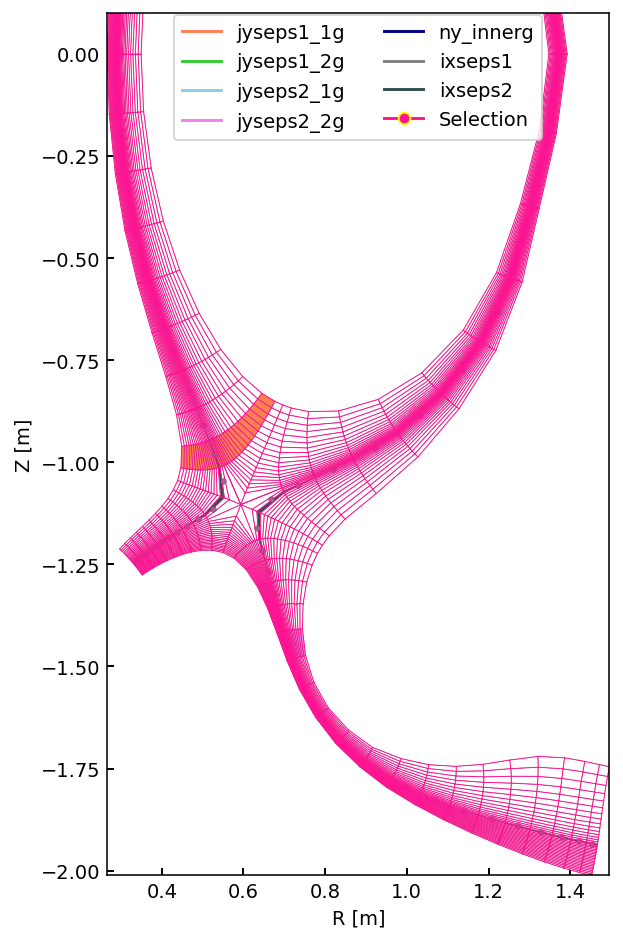

In [116]:
fig, ax = plt.subplots(figsize = (8,8))

xhermes.plotting.plot_rz_grid(hypno_ng, ax=ax, mode = "poloidal", ylim = (None, 0.1))

for x0, x1 in edges:
    ax.plot([x0[0], x1[0]], [x0[1], x1[1]], color='deeppink', linewidth=0.5)

# Path tests

In [20]:
print(dmplex_path)

/home/mike/work/hermes3v/builds/newbuild/tests/integrated/dmplex/hypnotoad_dmplex_mesh_output.h5


In [17]:
to_remove = []
for file in case_path.glob(".BOUT.pid.*"):
    to_remove.append(file)
    
for file in case_path.glob("BOUT.log.*"):
    to_remove.append(file)
    
for file in case_path.glob("BOUT.dmp.*.nc"):
    to_remove.append(file)
    
for file in case_path.glob("BOUT.settings"):
    to_remove.append(file)
    
if len(to_remove) > 0:
    for file in to_remove:
        shell(f"rm {file}")
    
if logfile.exists():
    shell(f"rm {logfile}")